## 変更点

- run()を add_all_features(), split_train_test_pair() と train() に分離
- train() でモデル名を指定して学習と推論
- 予測値は confidence_{model_name} に出力

## Change Logs

- shopee-submission-pipeline_v0507-1100.ipynb
    - テキストの正規化処理を追加
    - CV F1: 0.7555
- shopee-submission-pipeline_v0507-1200.ipynb
    - グラフ特徴量を追加
    - CV F1: 0.7799
- shopee-submission-pipeline_v0507-1300.ipynb
    - CV F1: 0.7809
- shopee-submission-pipeline_v0507-2100.ipynb
    - CV F1: 0.7812
- shopee-submission-pipeline_v0507-2200.ipynb
    - CV F1: 0.7817
    - effnet b3 512x512をembeddins抽出に追加
- shopee-submission-pipeline_v0508-0900.ipynb
    - CV F1: 0.7826
    - 類似度同士の積を特徴量として追加
    - コサイン類似度のメモリ節約&高速化
- shopee-submission-pipeline_v0508-1500.ipynb
    - CV F1: 0.7837
    - TF-IDFでstop wordsやbinary=True, max_featuresを追加
- 👑  shopee-submission-pipeline_v0508-1600.ipynb
    - CV F1: 0.7848
    - num kfolds を 2 -> 5に変更

In [55]:
import warnings
warnings.filterwarnings('ignore')

import os
import sys
import pandas as pd

if "google.colab" in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    %cd /content/drive/MyDrive/git/kaggle-shopee/working

    !pip install python-Levenshtein
    !pip install tensorflow-addons
    !pip install timm
    
    #!pip install -U pandas
    !pip install -U xgboost
    !pip install -U albumentations
    !pip install -U python-igraph
    !pip install -U unidecode
    !pip install catboost
    !pip install -U transformers

    if not os.path.exists("/content/shopee-product-matching"):
        os.makedirs("/content/shopee-product-matching")
        !cp ../input/shopee-product-matching.zip /content/shopee-product-matching
        !unzip /content/shopee-product-matching/shopee-product-matching.zip -d /content/shopee-product-matching

#sys.path.append('../input/pytorch-image-models/pytorch-image-models-master')
sys.path.append("/content/drive/MyDrive/git/kaggle-shopee/input/shopee-toolkit")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/git/kaggle-shopee/working
Requirement already up-to-date: xgboost in /usr/local/lib/python3.7/dist-packages (1.4.1)
Requirement already up-to-date: albumentations in /usr/local/lib/python3.7/dist-packages (0.5.2)
Requirement already up-to-date: python-igraph in /usr/local/lib/python3.7/dist-packages (0.9.1)
Requirement already up-to-date: unidecode in /usr/local/lib/python3.7/dist-packages (1.2.0)
Requirement already up-to-date: transformers in /usr/local/lib/python3.7/dist-packages (4.5.1)


In [72]:
# keras のメモリ
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)
        print('{} memory growth: {}'.format(device, tf.config.experimental.get_memory_growth(device)))
else:
    print("Not enough GPU hardware devices available")

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU') memory growth: True


In [110]:
'''
import shopee
'''
%load_ext autoreload
%autoreload
import shopee

import gc


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [144]:
class Config:
    def __init__(self, debug:bool):
        self.debug = debug # Trueならメモリや実行時間を超えないか検証
        self.suffix = "_debug" if self.debug else ""
        self.train_nrows = 1000
        self.image_size = 256
        self.batch_size = 32
        self.num_kfolds = 5
        self.max_candidates = 20
        self.max_seq_length = 100
        self.use_graph_features = True
        self.use_cache = True
        self.weight_rate = 1 # xgbモデル学習時に利用するpositiveクラスの重み
        self.use_fast_neighbors = True # 候補点抽出時にGPUを使うかどうか(メモリ使用量大)
        self.use_units_features = True # 単位抽出特徴量を利用するかどうか
        # 画像特徴量抽出アルゴリズム
        self.entry_ids = [
            # "effnet-b0_512x512",
            "effnet-b3_512x512",
            # "effnet-b5_512x512",
            "effnet-b0_256x256",
            # "effnet-b3_256x256",
            # "effnet-b5_256x256",
            # "mobilenet-v2_256x256",
            "tfidf-v1",
            # "roberta-base",
            # "bert-base-uncased",
            # "bert-base-multilingual-uncased",
        ]
        self.feature_names = [
            "edit_distance",
            "feat_effnet-b0_256x256",
            "feat_effnet-b0_256x256_x_feat_tfidf-v1",
            "feat_effnet-b3_512x512",
            "feat_effnet-b3_512x512_x_feat_effnet-b0_256x256",
            "feat_effnet-b3_512x512_x_feat_tfidf-v1",
            "feat_tfidf-v1",
        ]
        if self.use_graph_features:
            self.feature_names += [
                "neighborhood_size1_pid","neighborhood_size1_cpid","neighborhood_size1_diff",
                "neighborhood_size2_pid","neighborhood_size2_cpid","neighborhood_size2_diff",
                "authority_score_pid","authority_score_cpid","authority_score_diff",
                "constraint_pid","constraint_cpid","constraint_diff",
                "pagerank_pid", "pagerank_cpid", "pagerank_diff",
                "strength_pid","strength_cpid","strength_diff",
                "transitivity_local_undirected_pid", "transitivity_local_undirected_cpid", "transitivity_local_undirected_diff",
                "intersection_neighbors_num", "union_neighbors_num", "xor_neighbors_num", "intersection_neighbors_rate"
            ]
        if self.use_units_features:
            self.units_names = [
                    "gram",
                    "kg",
                    "ampere",
                    "volt",
                    "inch",
                    "cm",
                    "mm",
                    "ml",
                    "liter",
                    "meter",
                    "tahun",
                    "bulan"
            ]

            self.feature_names += self.units_names
        self.data_directory = "./data"
        self.pair_filepath = os.path.join(
            self.data_directory,
            f"pair_matching{self.suffix}.csv"
        )

config = Config(debug=False)
os.makedirs(config.data_directory, exist_ok=True)

## Load dataset

In [145]:
train_df = shopee.datasets.load_train_data()
if config.debug:
    train_df = train_df.head(200)
test_df = shopee.datasets.load_test_data()

if "google.colab" in sys.modules:
    train_df["filepath"] = train_df["image"].apply(lambda _: os.path.join("/content/shopee-product-matching/train_images", _))
    test_df["filepath"] = test_df["image"].apply(lambda _: os.path.join("/content/shopee-product-matching/test_images", _))

## Pair matching


In [146]:
%%time
pair_df = shopee.matching.make_candidates(
    debug=config.debug,
    train_df=train_df,
    test_df=test_df,
    use_cache=config.use_cache,
    entry_ids=config.entry_ids,
    max_candidates=config.max_candidates,
    max_seq_length=config.max_seq_length,
    use_fast_neighbors=config.use_fast_neighbors
)

Calculate embeddings with effnet-b3_512x512
Load from ../input/shopee-train-embeddings/train-embeddings-effnet-b3_512x512.npy
{'id': 'effnet-b3_512x512', 'classname': '<function EfficientNetB3 at 0x7f3c99b660e0>', 'model_type': 'keras-origin', 'weights_filepath': '../input/all-in-one-packages/models/effnet-b3.h5', 'train_embeddings_filepath': '../input/shopee-train-embeddings/train-embeddings-effnet-b3_512x512.npy', 'image_size': 512}
1/1 [==============================] - 2s 2s/step
Calculate embeddings with effnet-b0_256x256
Load from ../input/shopee-train-embeddings/train-embeddings-effnet-b0_256x256.npy
{'id': 'effnet-b0_256x256', 'classname': '<function EfficientNetB0 at 0x7f3c99b5eef0>', 'model_type': 'keras-origin', 'weights_filepath': '../input/all-in-one-packages/models/effnet-b0.h5', 'train_embeddings_filepath': '../input/shopee-train-embeddings/train-embeddings-effnet-b0_256x256.npy', 'image_size': 256}
1/1 [==============================] - 1s 1s/step
Calculate embeddings w

100%|██████████| 343/343 [00:01<00:00, 227.37it/s]


<class 'numpy.ndarray'>
no


  2%|▏         | 6/343 [00:00<00:06, 51.12it/s]

<class 'scipy.sparse.csr.csr_matrix'>
ok


100%|██████████| 343/343 [00:06<00:00, 51.31it/s]


candidate indices 34253
calculate distance
CPU times: user 1min 11s, sys: 19.9 s, total: 1min 31s
Wall time: 1min 12s


In [147]:
print(f"Save to {config.pair_filepath}")
pair_df.to_csv(config.pair_filepath, index=False)

Save to ./data/pair_matching.csv


## 特徴量


In [148]:
%%time
""" add_all_features, split_train_test_pair と train に分割
train_pair_df, test_pair_df = shopee.training.run(
    train_df,
    test_df,
    pair_df,
    weight_rate=config.weight_rate,
    use_graph_features=config.use_graph_features,
    num_kfolds=config.num_kfolds,
    feature_names=config.feature_names,
)
"""

# 特徴量の追加
shopee.feature_extraction.add_all_features(
    train_df,
    test_df,
    pair_df,
    use_units_features = config.use_units_features,
    use_graph_features=config.use_graph_features,
    units_names = config.units_names
)


gram
kg
ampere
volt
inch
cm
mm
ml
liter
meter
tahun
bulan
making graph features ...
 neighborhood_size1
 neighborhood_size2
 authority_score
 constraint
 pagerank
 strength
 transitivity_local_undirected(clustering coefficient)
Memory usage of properties dataframe is : 569.2099533081055  MB
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  221.0230884552002  MB
This is  38.82980035234265 % of the initial size
 making neighbors set
 intersection
 union
 xor
CPU times: user 2min 36s, sys: 2.75 s, total: 2min 39s
Wall time: 2min 37s


In [149]:
# 全単位特徴量の総和を使う
if config.use_units_features:
    pair_df["units_sum"] = 0
    for unit in  config.units_names:
        pair_df["units_sum"] += pair_df[unit]
    config.feature_names += ["units_sum"]

In [150]:
config.feature_names = list(set(config.feature_names))

In [151]:
pair_df[pair_df["ml"] != 0]

,posting_id,candidate_posting_id,matched,feat_effnet-b3_512x512,feat_effnet-b0_256x256,feat_tfidf-v1,gram,kg,ampere,volt,inch,cm,mm,ml,liter,meter,tahun,bulan,posting_id_phash,candidate_posting_id_phash,edit_distance,feat_effnet-b3_512x512_x_feat_effnet-b0_256x256,feat_effnet-b3_512x512_x_feat_tfidf-v1,feat_effnet-b0_256x256_x_feat_tfidf-v1,posting_id_index,candidate_posting_id_index,neighborhood_size1_pid,neighborhood_size1_cpid,neighborhood_size1_diff,neighborhood_size2_pid,neighborhood_size2_cpid,neighborhood_size2_diff,authority_score_pid,authority_score_cpid,authority_score_diff,constraint_pid,constraint_cpid,constraint_diff,pagerank_pid,pagerank_cpid,pagerank_diff,strength_pid,strength_cpid,strength_diff,transitivity_local_undirected_pid,transitivity_local_undirected_cpid,transitivity_local_undirected_diff,posting_neighbors_set,candidate_neighbors_set,intersection_neighbors_num,union_neighbors_num,intersection_neighbors_rate,xor_neighbors_num,units_sum
195,train_3369186413,train_3369186413,1,1.000000,1.000000,1.000000,0,0,0,0,0,0,0,1,0,0,0,0,a6f319f924ad708c,a6f319f924ad708c,0,1.000000,1.000000,1.000000,4,4,265,265,0,8942,8942,0,5.936874e-08,5.936874e-08,0.000000e+00,-0.988008,-0.988008,-1.000000,0.000018,0.000018,0.000000,3.438764,3.438764,0.000000,0.014316,0.014316,0.000000,"{11776, 4097, 22530, 20483, 8708, 12805, 14852...","{11776, 4097, 22530, 20483, 8708, 12805, 14852...",264,266,0.992481,2,1
197,train_3369186413,train_269910546,0,0.717757,0.692574,0.000000,0,0,0,0,0,0,0,-1,0,0,0,0,a6f319f924ad708c,b38ccc66cc336699,16,0.497099,0.000000,0.000000,4,28041,265,69,196,8942,2528,6414,5.936874e-08,2.577906e-05,2.571969e-05,-0.988008,0.150873,-1.000000,0.000018,0.000030,0.000012,3.438764,7.484258,4.045494,0.014316,0.176471,0.162154,"{11776, 4097, 22530, 20483, 8708, 12805, 14852...","{33921, 24194, 31490, 4, 29444, 16391, 12415, ...",10,324,0.030864,314,-1
198,train_3369186413,train_2890561395,0,0.699857,0.646705,0.000000,0,0,0,0,0,0,0,-1,0,0,0,0,a6f319f924ad708c,d046c656c6bbc639,16,0.452601,0.000000,0.000000,4,9354,265,66,199,8942,2783,6159,5.936874e-08,1.448547e-08,4.488327e-08,-0.988008,0.086181,-1.000000,0.000018,0.000013,0.000005,3.438764,2.308628,1.130136,0.014316,0.131250,0.116934,"{11776, 4097, 22530, 20483, 8708, 12805, 14852...","{2560, 4, 12164, 11910, 6151, 19974, 29959, 14...",13,318,0.040881,305,-1
200,train_3369186413,train_3180859961,0,0.565431,0.680271,0.000000,0,0,0,0,0,0,0,-1,0,0,0,0,a6f319f924ad708c,b3f30df08c8ccc8d,12,0.384647,0.000000,0.000000,4,5133,265,57,208,8942,2239,6703,5.936874e-08,1.270419e-04,1.269825e-04,-0.988008,0.197027,-1.000000,0.000018,0.000020,0.000002,3.438764,4.138642,0.699878,0.014316,0.135714,0.121398,"{11776, 4097, 22530, 20483, 8708, 12805, 14852...","{13058, 13315, 4, 27779, 29451, 22540, 23053, ...",0,322,0.000000,322,-1
202,train_3369186413,train_921438619,1,0.834954,0.856652,0.624947,0,0,0,0,0,0,0,1,0,0,0,0,a6f319f924ad708c,e69999663199cc93,14,0.715265,0.521802,0.535362,4,18449,265,56,209,8942,1913,7029,5.936874e-08,4.526750e-08,1.410124e-08,-0.988008,0.248447,-1.000000,0.000018,0.000015,0.000003,3.438764,2.673784,0.764979,0.014316,0.212795,0.198478,"{11776, 4097, 22530, 20483, 8708, 12805, 14852...","{31616, 28417, 4, 19974, 3720, 28041, 29452, 2...",33,288,0.114583,255,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1586950,train_3480437118,train_2087941785,0,0.752725,0.744344,0.078649,0,0,0,0,0,0,0,-1,0,0,0,0,ab37362b173630aa,e6cb9834b694d136,15,0.560286,0.059201,0.058542,34243,31075,52,63,11,1617,2001,384,8.760284e-06,6.866051e-05,5.990022e-05,0.155140,0.102113,0.053027,0.000034,0.000025,0.000009,12.969542,8.971552,3.997990,0.320784,0.185087,0.135697,"{13953, 22532, 29316, 28427, 10765, 31117, 176...","{6272, 13953, 25344, 11139, 22532, 25859, 8326...",18,97,0.185567,79,-1
1586951,train_3480437118,tr

In [152]:

# train, test への分割
train_pair_df, test_pair_df = shopee.training.split_train_test_pair(
    train_df,
    test_df,
    pair_df,
)


In [153]:
# メモリ削減
del pair_df
_ = gc.collect()

In [154]:
# 理論値(正解を突っ込んでるだけなので100%当たった状態)
train_pair_df["prediction"] = train_pair_df["matched"].copy()
shopee.metrics.show_score(train_df, train_pair_df)

positive ratio: 0.1098
total: 201752
TP: 174309
FP: 0
FN: 27443
TN: 1413081
F1: 0.9719


## xgb 

In [155]:
config.feature_names

['constraint_cpid',
 'neighborhood_size1_diff',
 'constraint_pid',
 'feat_effnet-b3_512x512_x_feat_tfidf-v1',
 'kg',
 'tahun',
 'pagerank_pid',
 'cm',
 'ml',
 'edit_distance',
 'authority_score_cpid',
 'strength_pid',
 'gram',
 'meter',
 'inch',
 'authority_score_pid',
 'neighborhood_size2_cpid',
 'strength_diff',
 'transitivity_local_undirected_pid',
 'xor_neighbors_num',
 'feat_effnet-b0_256x256',
 'feat_effnet-b3_512x512',
 'liter',
 'mm',
 'strength_cpid',
 'transitivity_local_undirected_diff',
 'neighborhood_size1_pid',
 'pagerank_cpid',
 'neighborhood_size2_diff',
 'ampere',
 'bulan',
 'neighborhood_size1_cpid',
 'units_sum',
 'pagerank_diff',
 'volt',
 'intersection_neighbors_rate',
 'feat_effnet-b0_256x256_x_feat_tfidf-v1',
 'transitivity_local_undirected_cpid',
 'constraint_diff',
 'union_neighbors_num',
 'authority_score_diff',
 'intersection_neighbors_num',
 'feat_effnet-b3_512x512_x_feat_effnet-b0_256x256',
 'feat_tfidf-v1',
 'neighborhood_size2_pid']

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.2832336307209388, max_delta_step=None,
              max_depth=5, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=1463, n_jobs=None,
              num_parallel_tree=None, objective='binary:logistic',
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method='gpu_hist',
              use_label_encoder=True, validate_parameters=None, verbosity=None)
[0]	validation_0-logloss:0.49016	validation_1-logloss:0.52394
[10]	validation_0-logloss:0.13984	validation_1-logloss:0.25831
[20]	validation_0-logloss:0.12281	validation_1-logloss:0.24761
[30]	validation_0-logloss:0.11754	validation_1-logloss:0.24338
[40]	validation_0-logloss:0.1142

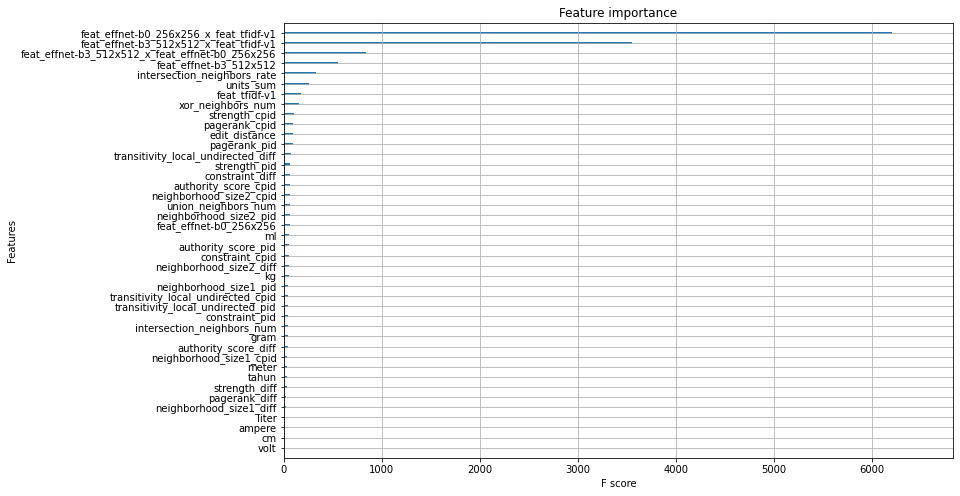

no importance ['inch', 'mm', 'bulan']
XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.2832336307209388, max_delta_step=None,
              max_depth=5, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=1463, n_jobs=None,
              num_parallel_tree=None, objective='binary:logistic',
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method='gpu_hist',
              use_label_encoder=True, validate_parameters=None, verbosity=None)
[0]	validation_0-logloss:0.48949	validation_1-logloss:0.52505
[10]	validation_0-logloss:0.13882	validation_1-logloss:0.26528
[20]	validation_0-logloss:0.12146	validation_1-logloss:0.25534
[30]	validation_0-logloss:0.11629	validation_1-logloss:0.

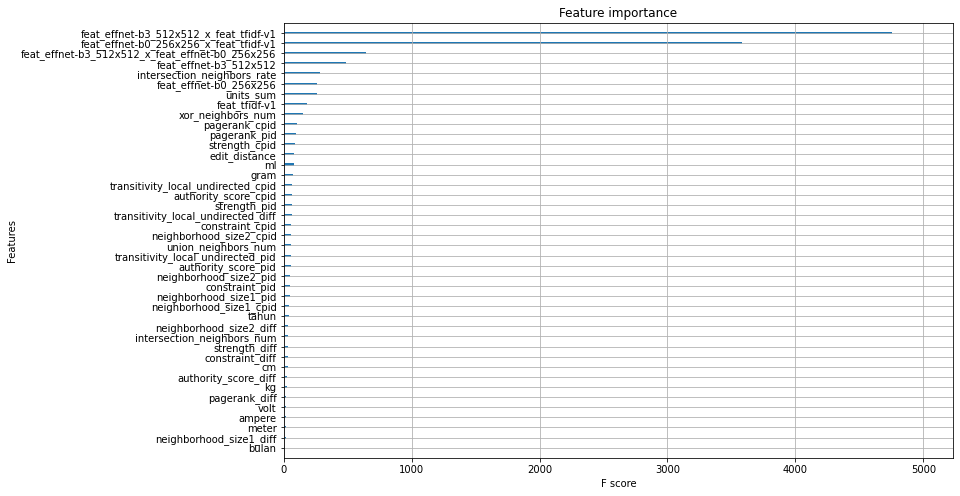

no importance ['inch', 'liter', 'mm']
XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.2832336307209388, max_delta_step=None,
              max_depth=5, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=1463, n_jobs=None,
              num_parallel_tree=None, objective='binary:logistic',
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method='gpu_hist',
              use_label_encoder=True, validate_parameters=None, verbosity=None)
[0]	validation_0-logloss:0.48966	validation_1-logloss:0.52385
[10]	validation_0-logloss:0.13838	validation_1-logloss:0.25392
[20]	validation_0-logloss:0.12144	validation_1-logloss:0.24526
[30]	validation_0-logloss:0.11593	validation_1-logloss:0.

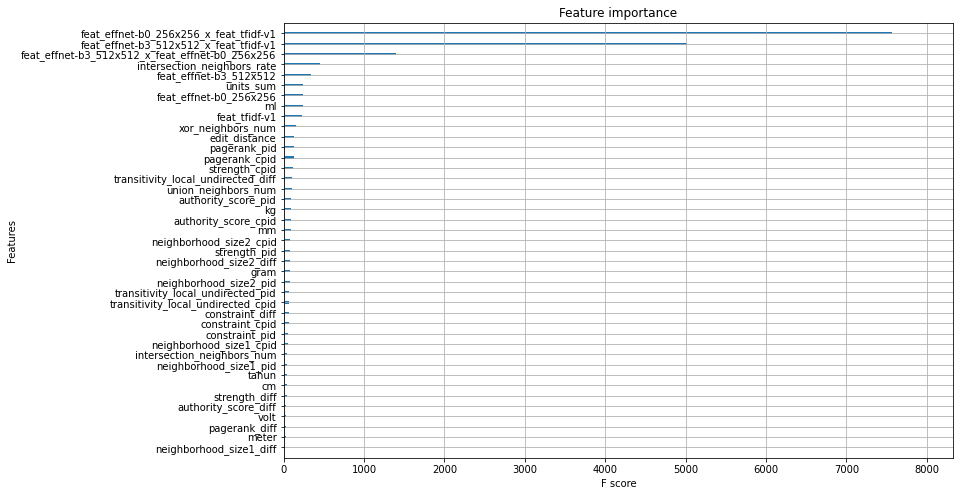

no importance ['inch', 'liter', 'ampere', 'bulan']
XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.2832336307209388, max_delta_step=None,
              max_depth=5, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=1463, n_jobs=None,
              num_parallel_tree=None, objective='binary:logistic',
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method='gpu_hist',
              use_label_encoder=True, validate_parameters=None, verbosity=None)
[0]	validation_0-logloss:0.48977	validation_1-logloss:0.52204
[10]	validation_0-logloss:0.13853	validation_1-logloss:0.26039
[20]	validation_0-logloss:0.12086	validation_1-logloss:0.25515
[30]	validation_0-logloss:0.11551	validation

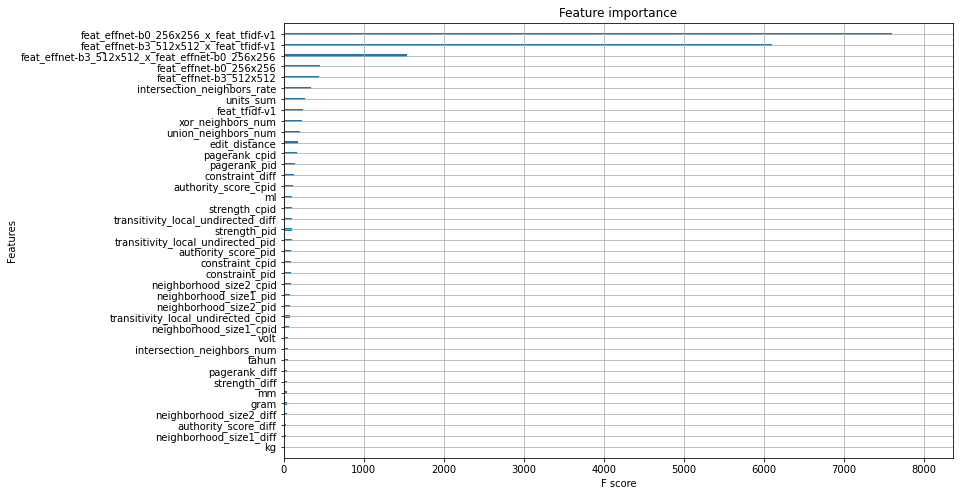

no importance ['cm', 'meter', 'inch', 'liter', 'ampere', 'bulan']
XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.2832336307209388, max_delta_step=None,
              max_depth=5, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=1463, n_jobs=None,
              num_parallel_tree=None, objective='binary:logistic',
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method='gpu_hist',
              use_label_encoder=True, validate_parameters=None, verbosity=None)
[0]	validation_0-logloss:0.48994	validation_1-logloss:0.52504
[10]	validation_0-logloss:0.13949	validation_1-logloss:0.26080
[20]	validation_0-logloss:0.12209	validation_1-logloss:0.25110
[30]	validation_0-logloss:0.1

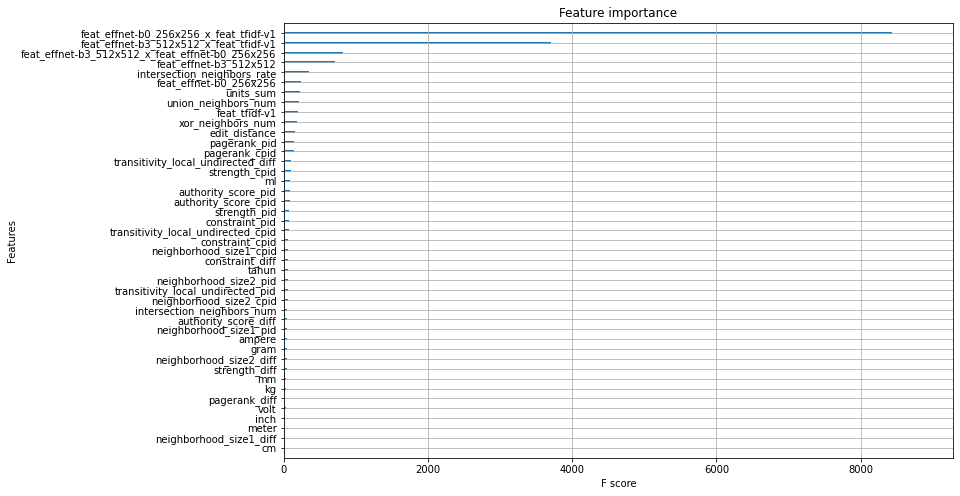

no importance ['liter', 'bulan']
CPU times: user 28.9 s, sys: 1.48 s, total: 30.4 s
Wall time: 23.4 s


In [156]:
%%time

train_pair_df, test_pair_df = shopee.training.train(
    train_df,
    test_df,
    train_pair_df, test_pair_df,
    weight_rate=config.weight_rate,
    num_kfolds=config.num_kfolds,
    feature_names=config.feature_names,
    model_name="xgb"
)

In [157]:
# --------------------------- new
train_pair_df["confidence"] = train_pair_df["confidence_xgb"]
test_pair_df["confidence"] = test_pair_df["confidence_xgb"]
# ---------------------------


# テストと同程度のpositive:negativeの割合になるように調整しておく
import random
train_pair_only = train_pair_df.loc[
    (train_pair_df["posting_id"].str.contains("train_", na=False) & 
    train_pair_df["candidate_posting_id"].str.contains("train_", na=False)),
    ["posting_id","candidate_posting_id", "matched", "confidence"]
]
train_cpid_test = train_pair_df.loc[
    (train_pair_df["posting_id"].str.contains("train_", na=False) & train_pair_df["candidate_posting_id"].str.contains("test_", na=False)),
    ["posting_id","candidate_posting_id", "matched", "confidence"]
].sample(frac=0.5)
train_pair_only = pd.concat([
    train_pair_only,
    train_cpid_test
])

best, threshold = shopee.optimization.find_optimal_threshold(
    df=train_df,
    pair_df=train_pair_only
)

print("optimial threshold: %.4f" % threshold)
train_pair_df["prediction"] = (train_pair_df["confidence"] > threshold).astype(int)
shopee.metrics.show_score(train_df, train_pair_df)

optimial threshold: 0.4687
positive ratio: 0.1098
total: 201752
TP: 133220
FP: 33541
FN: 68532
TN: 1379540
F1: 0.7896


# テキスト調整前

## 絞る
```

                                "liter", #
                                "ml", #
                                "gram", #: 3018
                                "piece", #:1200
                                "kg", #: 795
                                "ampere", #: 248
                                "mm", #: 328
                                "box", #:424
                                "cm", #: 737
                                "buku", #:308
                                "meter", #: 459
                                "inch", #: 147
                                "lembar", #: 73
                                "sachet", #:169
                                "pasang", #: 96
                                "watt", #:157
                                "biji", #:40
                                "lusin", #:62
                                "volt", #: 118
                                "batang", #:30
                                "pack" , #: 349
                                "botol", #:349
F1: 0.7893
```

## 全部
```
"liter", "ml", "gram","kg",
                    "ampere",
                    "volt",
                    "inch",
                    "cm",
                    "mm",
                    "meter",
                    "butir","batang","buku","biji", "piece", "lembar", "watt", "botol", "pasang", "lusin", "cc", "box", "sachet","tingkat","ply", "pack"
```
F1: 0.7890

## 前処理を強化
F1: 0.7900

## 単位追加
```
                    "gram",
                    "kg",
                    "ampere",
                    "volt",
                    "inch",
                    "cm",
                    "mm",
                    "ml",
                    "liter",
                    "meter",
                    "tahun",
                    "bulan"
F1: 0.7901
```

ベース
```
[                   “liter”,
                    “ml”,
                    “gram”,
                    “kg”,
                    “ampere”,
                    “volt”,
                    “inch”,
                    “cm”,
                    “mm”,
                    “meter”,           ]
F1: 0.7866→F1: 0.7893
```

# catboost


In [158]:
%%time
train_pair_df, test_pair_df = shopee.training.train(
    train_df,
    test_df,
    train_pair_df, test_pair_df,
    weight_rate=config.weight_rate,
    num_kfolds=config.num_kfolds, # fold数を2に
    feature_names=config.feature_names,
    model_name="cat"
)

0:	learn: 0.6706311	total: 44.8ms	remaining: 44.8s
100:	learn: 0.1527427	total: 2.14s	remaining: 19.1s
200:	learn: 0.1261993	total: 4.18s	remaining: 16.6s
300:	learn: 0.1194857	total: 6.21s	remaining: 14.4s
400:	learn: 0.1156748	total: 8.23s	remaining: 12.3s
500:	learn: 0.1126396	total: 10.3s	remaining: 10.2s
600:	learn: 0.1100607	total: 12.3s	remaining: 8.18s
700:	learn: 0.1078518	total: 14.3s	remaining: 6.11s
800:	learn: 0.1057779	total: 16.4s	remaining: 4.07s
900:	learn: 0.1039392	total: 18.4s	remaining: 2.02s
999:	learn: 0.1022043	total: 20.4s	remaining: 0us


0:	learn: 0.6706102	total: 24.3ms	remaining: 24.2s
100:	learn: 0.1513291	total: 2.09s	remaining: 18.6s
200:	learn: 0.1253164	total: 4.15s	remaining: 16.5s
300:	learn: 0.1188029	total: 6.18s	remaining: 14.3s
400:	learn: 0.1151901	total: 8.21s	remaining: 12.3s
500:	learn: 0.1122471	total: 10.3s	remaining: 10.2s
600:	learn: 0.1098384	total: 12.3s	remaining: 8.15s
700:	learn: 0.1076847	total: 14.3s	remaining: 6.1s
800:	learn: 0.1057822	total: 16.4s	remaining: 4.07s
900:	learn: 0.1040470	total: 18.4s	remaining: 2.02s
999:	learn: 0.1023948	total: 20.4s	remaining: 0us


0:	learn: 0.6703934	total: 24.5ms	remaining: 24.5s
100:	learn: 0.1515120	total: 2.14s	remaining: 19s
200:	learn: 0.1253185	total: 4.18s	remaining: 16.6s
300:	learn: 0.1184198	total: 6.15s	remaining: 14.3s
400:	learn: 0.1145708	total: 8.13s	remaining: 12.1s
500:	learn: 0.1116583	total: 10.1s	remaining: 10.1s
600:	learn: 0.1091630	total: 12.1s	remaining: 8.03s
700:	learn: 0.1070016	total: 14.1s	remaining: 6s
800:	learn: 0.1050443	total: 16.1s	remaining: 3.99s
900:	learn: 0.1032682	total: 18s	remaining: 1.98s
999:	learn: 0.1016521	total: 20s	remaining: 0us


0:	learn: 0.6706714	total: 24ms	remaining: 24s
100:	learn: 0.1511384	total: 2.12s	remaining: 18.9s
200:	learn: 0.1245860	total: 4.17s	remaining: 16.6s
300:	learn: 0.1177732	total: 6.18s	remaining: 14.4s
400:	learn: 0.1137452	total: 8.21s	remaining: 12.3s
500:	learn: 0.1106222	total: 10.3s	remaining: 10.2s
600:	learn: 0.1080880	total: 12.3s	remaining: 8.16s
700:	learn: 0.1058771	total: 14.3s	remaining: 6.11s
800:	learn: 0.1038729	total: 16.3s	remaining: 4.06s
900:	learn: 0.1021016	total: 18.4s	remaining: 2.02s
999:	learn: 0.1005201	total: 20.4s	remaining: 0us


0:	learn: 0.6709445	total: 23.6ms	remaining: 23.6s
100:	learn: 0.1525076	total: 2.13s	remaining: 19s
200:	learn: 0.1257163	total: 4.16s	remaining: 16.5s
300:	learn: 0.1189176	total: 6.13s	remaining: 14.2s
400:	learn: 0.1150387	total: 8.11s	remaining: 12.1s
500:	learn: 0.1119668	total: 10.1s	remaining: 10.1s
600:	learn: 0.1094766	total: 12.2s	remaining: 8.07s
700:	learn: 0.1073320	total: 14.2s	remaining: 6.06s
800:	learn: 0.1053677	total: 16.2s	remaining: 4.03s
900:	learn: 0.1036061	total: 18.2s	remaining: 2s
999:	learn: 0.1019560	total: 20.3s	remaining: 0us
CPU times: user 3min 42s, sys: 1min 35s, total: 5min 18s
Wall time: 3min 34s


In [159]:
# --------------------------- new
train_pair_df["confidence"] = train_pair_df["confidence_cat"]
test_pair_df["confidence"] = test_pair_df["confidence_cat"]
# ---------------------------



# テストと同程度のpositive:negativeの割合になるように調整しておく
import random
train_pair_only = train_pair_df.loc[
    (train_pair_df["posting_id"].str.contains("train_", na=False) & 
    train_pair_df["candidate_posting_id"].str.contains("train_", na=False)),
    ["posting_id","candidate_posting_id", "matched", "confidence"]
]
train_cpid_test = train_pair_df.loc[
    (train_pair_df["posting_id"].str.contains("train_", na=False) & train_pair_df["candidate_posting_id"].str.contains("test_", na=False)),
    ["posting_id","candidate_posting_id", "matched", "confidence"]
].sample(frac=0.5)
train_pair_only = pd.concat([
    train_pair_only,
    train_cpid_test
])

best, threshold = shopee.optimization.find_optimal_threshold(
    df=train_df,
    pair_df=train_pair_only
)

print("optimial threshold: %.4f" % threshold)
train_pair_df["prediction"] = (train_pair_df["confidence"] > threshold).astype(int)
shopee.metrics.show_score(train_df, train_pair_df)

optimial threshold: 0.4722
positive ratio: 0.1098
total: 201752
TP: 133581
FP: 32399
FN: 68171
TN: 1380682
F1: 0.7940


In [160]:
'''%load_ext autoreload
%autoreload
import shopee'''

'%load_ext autoreload\n%autoreload\nimport shopee'

# neuralnet

In [161]:
%%time
# 何もしない場合は欠損値は自動で平均埋め
train_pair_df, test_pair_df = shopee.training.train(
    train_df,
    test_df,
    train_pair_df, test_pair_df,
    weight_rate=config.weight_rate,
    num_kfolds=2,#config.num_kfolds, # fold数を2に
    feature_names=config.feature_names,
    model_name="nn"
)

X_train: 440197 X_valid: 441717  X_allvalid: 792944
FOLD:0, EPOCH: 0, train_loss: 0.1632, valid_loss: 0.1577
FOLD:0, EPOCH: 1, train_loss: 0.1541, valid_loss: 0.1642
FOLD:0, EPOCH: 2, train_loss: 0.1517, valid_loss: 0.1556
FOLD:0, EPOCH: 3, train_loss: 0.1502, valid_loss: 0.1783
FOLD:0, EPOCH: 4, train_loss: 0.1491, valid_loss: 0.1682
FOLD:0, EPOCH: 5, train_loss: 0.1481, valid_loss: 0.1727


KeyboardInterrupt: ignored

In [ ]:
train_pair_df["confidence"] = train_pair_df["confidence_nn"]
test_pair_df["confidence"] = test_pair_df["confidence_nn"]



# テストと同程度のpositive:negativeの割合になるように調整しておく
import random
train_pair_only = train_pair_df.loc[
    (train_pair_df["posting_id"].str.contains("train_", na=False) & 
    train_pair_df["candidate_posting_id"].str.contains("train_", na=False)),
    ["posting_id","candidate_posting_id", "matched", "confidence"]
]
train_cpid_test = train_pair_df.loc[
    (train_pair_df["posting_id"].str.contains("train_", na=False) & train_pair_df["candidate_posting_id"].str.contains("test_", na=False)),
    ["posting_id","candidate_posting_id", "matched", "confidence"]
].sample(frac=0.5)
train_pair_only = pd.concat([
    train_pair_only,
    train_cpid_test
])

best, threshold = shopee.optimization.find_optimal_threshold(
    df=train_df,
    pair_df=train_pair_only
)

print("optimial threshold: %.4f" % threshold)
train_pair_df["prediction"] = (train_pair_df["confidence"] > threshold).astype(int)
shopee.metrics.show_score(train_df, train_pair_df)

del train_pair_only
_ = gc.collect()

In [ ]:
'''import matplotlib.pyplot as plt
import seaborn as sns
sns.histplot(data=train_pair_df, x="confidence_nn", hue="matched",bins=40, log_scale=(False, False))
'''

## emsemble

In [ ]:
rates = {
    "xgb": 0.2,
    "cat": 0.6,
    "nn": 0.2,
}
train_pair_df["confidence"] = (train_pair_df["confidence_nn"]*rates["nn"] + train_pair_df["confidence_xgb"]*rates["xgb"] + train_pair_df["confidence_cat"]*rates["cat"])
test_pair_df["confidence"] = (test_pair_df["confidence_nn"]*rates["nn"] + test_pair_df["confidence_xgb"]*rates["xgb"] + test_pair_df["confidence_cat"]*rates["cat"])


# テストと同程度のpositive:negativeの割合になるように調整しておく
import random
train_pair_only = train_pair_df.loc[
    (train_pair_df["posting_id"].str.contains("train_", na=False) & 
    train_pair_df["candidate_posting_id"].str.contains("train_", na=False)),
    ["posting_id","candidate_posting_id", "matched", "confidence"]
]
train_cpid_test = train_pair_df.loc[
    (train_pair_df["posting_id"].str.contains("train_", na=False) & train_pair_df["candidate_posting_id"].str.contains("test_", na=False)),
    ["posting_id","candidate_posting_id", "matched", "confidence"]
].sample(frac=0.5)
train_pair_only = pd.concat([
    train_pair_only,
    train_cpid_test
])

best, threshold = shopee.optimization.find_optimal_threshold(
    df=train_df,
    pair_df=train_pair_only
)

print("optimial threshold: %.4f" % threshold)
train_pair_df["prediction"] = (train_pair_df["confidence"] > threshold).astype(int)
shopee.metrics.show_score(train_df, train_pair_df)

del train_pair_only
_ = gc.collect()

# グラフスタッキング


In [ ]:
pair_df = pd.concat([train_pair_df, test_pair_df])
pair_df = pair_df.rename(
    columns={
    "confidence_xgb":"pre_confidence_xgb",
    "confidence_cat":"pre_confidence_cat",
    "confidence_nn":"pre_confidence_nn",
    "confidence":"pre_confidence",
    }
)

In [ ]:
# 特徴量の追加
if config.use_graph_features:
    shopee.feature_extraction.add_graph_features(
        pair_df, 
        graph_weight = "pre_confidence"
    )

# train, test への分割
train_pair_df, test_pair_df = shopee.training.split_train_test_pair(
    train_df,
    test_df,
    pair_df,
)

In [ ]:
# 前の結果を新しい特徴量を追加
config.feature_names += ["pre_confidence", "pre_confidence_xgb", "pre_confidence_nn","pre_confidence_cat"]

In [ ]:
%%time
train_pair_df, test_pair_df = shopee.training.train(
    train_df,
    test_df,
    train_pair_df, test_pair_df,
    weight_rate=config.weight_rate,
    num_kfolds=config.num_kfolds,
    feature_names=config.feature_names,
    model_name="xgb"
)

In [ ]:
# --------------------------- new
train_pair_df["confidence"] = train_pair_df["confidence_xgb"]
test_pair_df["confidence"] = test_pair_df["confidence_xgb"]
# ---------------------------


# テストと同程度のpositive:negativeの割合になるように調整しておく
import random
train_pair_only = train_pair_df.loc[
    (train_pair_df["posting_id"].str.contains("train_", na=False) & 
    train_pair_df["candidate_posting_id"].str.contains("train_", na=False)),
    ["posting_id","candidate_posting_id", "matched", "confidence"]
]
train_cpid_test = train_pair_df.loc[
    (train_pair_df["posting_id"].str.contains("train_", na=False) & train_pair_df["candidate_posting_id"].str.contains("test_", na=False)),
    ["posting_id","candidate_posting_id", "matched", "confidence"]
].sample(frac=0.5)
train_pair_only = pd.concat([
    train_pair_only,
    train_cpid_test
])

best, threshold = shopee.optimization.find_optimal_threshold(
    df=train_df,
    pair_df=train_pair_only
)

print("optimial threshold: %.4f" % threshold)
train_pair_df["prediction"] = (train_pair_df["confidence"] > threshold).astype(int)
shopee.metrics.show_score(train_df, train_pair_df)

del train_pair_only
_ = gc.collect()

In [ ]:
test_pair_df["prediction"] = (test_pair_df["confidence"] > threshold).astype(int)
gdf = test_pair_df[test_pair_df["prediction"] == 1].groupby(
    "posting_id",
    as_index=False
)["candidate_posting_id"].apply(lambda _: " ".join(_))
submission_df = pd.read_csv("../input/shopee-product-matching/sample_submission.csv", usecols=["posting_id"])
submission_df = pd.merge(submission_df, gdf, on="posting_id", how="left")
submission_df = submission_df.rename(columns={
    "candidate_posting_id": "matches"
})
submission_df[["posting_id", "matches"]].to_csv("./submission.csv", index=False)

In [ ]:
# 提出形式の確認
!head ./submission.csv